# Trying to make a nice video of a cascade plume 



In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
import matplotlib.cm as cm
import matplotlib.pyplot as plt    # The code below assumes this convenient renaming
import math
import seaborn as sns
sns.set()
import time
import sys 
import pandas as pd

from binomial_function_collection import *

## Time stepping

In [5]:
def func_timestepping_smokestack(iadv):
    """
    Should have objects originating in one cell, and cascade while being advected
    
    """

    #--- time loop ----
    for t in range(ntim):


        t0 = time.time()
        

        #--- Energy cascade: decay of oldest objects in demographic record ---
        B_cas[:,:,:] = 0.
        if cascade_flag:
            for l in range(nsiz-1,0,-1):
                B_cas[:,:,l-1] = 2 * N[:,:,l,t-1,nage-1]   #split em in two, insert as birth of smaller objects
                #print("t=%s  l:%s  max B_cas:%s" % (t, l, np.max(B_cas[:,:,l])) )

                
        #--- species loop ---
        for l in range(nsiz):

            
            for i in range(nage-1,0,-1):

                #--- Object birthdays! Time-shift of the demographics levels ---
                #print("t=%s  l:%s  i:%s  max N:%s" % (t, l, i, np.max(N[:,:,l,t-1,i])) )
                N[:,:,l,t,i] = N[:,:,l,t-1,i-1]   #note: oldest level is forgotten

            
                #---Apply advection operator, after demographic shift ---
                if (iadv==1):
                    #advection for each age level separately
                    N[:,:,l,t,i] = func_advection_binomial_2D(N[:,:,l,t,i],u*dtim/dx,v*dtim/dy,periodic_flag=False)
        
            if (iadv==2):
                #1-age proxy
                dumN = func_advection_binomial_2D( np.sum(N[:,:,l,t,:],axis=2),u*dtim/dx,v*dtim/dy,periodic_flag=False)  

            


            #--- Births ---
            B = np.random.binomial(N_tot_ref[l], p[:,:,l,t].ravel(), nx*ny)
            B = B.reshape([nx,ny])
            # Warning! Need to make sure that the resizing is done correctly, so that x and y aren't swapped accidentally
            
            
            #--- Update object number: add births as level 1 demographics ---
            #N[:,:,l,t,0] = B                
            N[:,:,l,t,0] = B + B_cas[:,:,l]  # add births due to E-cascade
            
            #print( "t=%s  time = %s" % (t, t*dtim),' sizebin' ,l,'max birth: ',np.max(B),np.max(N[:,:,l,t,0]))
            
            
        t1 = time.time()

        dt_diag[iadv,t] = (t1-t0) / (nx*ny*nsiz)    #advection per age level per size species


        
    return N


# Settings  and initialization

In [6]:


#--- Grid parameters ----------
nx   = 20     #grid size
ny   = 10

#nsiz = 1       #nr of sizes in spectrum
nsiz = 5       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
ntim = 201    #nr of timesteps  12 hours

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 100.    #x gridspacing     [m]
dy   = 100.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]


#--- Reference domain ---
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]


#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)    #average nr of object births / m2 / s
#B_0[nsiz-1]    = 1.e-8  
#B_0[nsiz-1]    = 1.e-9  
B_0[nsiz-1]    = 5.e-6   

tau_D     = 600.    #object life time  [s]
#tau_D     = 150.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata


#--- pulsating growth parameters
pulse_growth_flag = 0
#pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
fac_pulse =  40.    #factor of proportionality in impact of pulsating growth on p


#--- energy cascade mode (big objects break up into smaller ones) ---
#cascade_flag = 0
cascade_flag = 1


#--- Advection parameters
u  = 0.4  #x wind, used for advection [m/s]
v  = 0.1  #y wind, used for advection [m/s]


#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)   #object number
p        = np.zeros( (nx,ny,nsiz,ntim) )                    #object birth probability
dp_pulse = np.empty( (nx,ny) )                     #perturbation in p due to pulsating growth (rule 1)
B_cas    = np.zeros( (nx,ny,nsiz) ).astype(int)    #births due to energy cascade



#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

#p[:,:,:,:] = prob_sub    #horizontally homogeneous
p[1,1,:,:] = prob_sub    #births at a single gridpoint only (plume mode)

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
            

#--- time diagnostics ---   
nadv = 3
dt_diag = np.empty( (nadv,ntim) )
            

prob_sub=1e-08
size=50.0 B0=0.0 N_tot_ref=0.0
size=150.0 B0=0.0 N_tot_ref=0.0
size=250.0 B0=0.0 N_tot_ref=0.0
size=350.0 B0=0.0 N_tot_ref=0.0
size=450.0 B0=5e-06 N_tot_ref=300000000.0


# Now the fun starts!

In [7]:
iadv=1
N = func_timestepping_smokestack(iadv);
    

# Plotting

In [8]:
# 70s colorbar :)
from matplotlib import cm
cmap = cm.get_cmap('cool_r',10)
cmap = cm.get_cmap('brg',5)
#cmap = func_generate_random_cmap(N_color=10)
color_rgb = [None]*5
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color_rgb[i] = matplotlib.colors.rgb2hex(rgb)

In [41]:
plt.text?

Signature: plt.text(x, y, s, fontdict=None, withdash=<deprecated parameter>, **kwargs)
Docstring:
Add text to the axes.

Add the text *s* to the axes at location *x*, *y* in data coordinates.

Parameters
----------
x, y : scalars
    The position to place the text. By default, this is in data
    coordinates. The coordinate system can be changed using the
    *transform* parameter.

s : str
    The text.

fontdict : dictionary, optional, default: None
    A dictionary to override the default text properties. If fontdict
    is None, the defaults are determined by your rc parameters.

withdash : boolean, optional, default: False
    Creates a `~matplotlib.text.TextWithDash` instance instead of a
    `~matplotlib.text.Text` instance.

Returns
-------
text : `.Text`
    The created `.Text` instance.

Other Parameters
----------------
**kwargs : `~matplotlib.text.Text` properties.
    Other miscellaneous text parameters.

Examples
--------
Individual keyword arguments can be used to overri

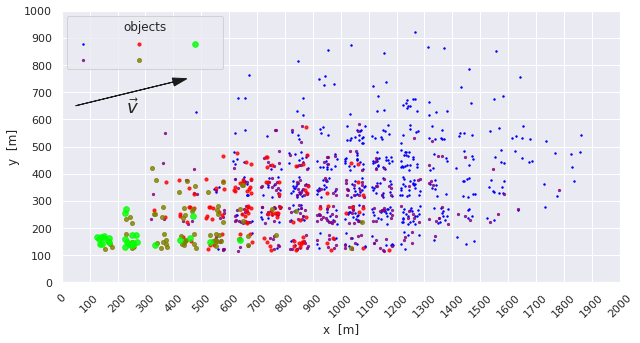

In [58]:
fig = plot_scatter_time(N,140,dx=dx,dy=dy,figsize=(10,5),color=color_rgb,sizes=[2,5,10,16,32],buffer=[0.875,0.85,0.825,0.8,0.75],alpha=[1.0,0.8,0.8,0.8,0.8],labels=[' ',' ',' ',' ',' '])

axes =plt.gca()
plt.xticks(rotation=45)
plt.legend(loc='upper left',ncol=3,title='objects')
plt.title('')

axes.arrow(50, 650, 400/8*7, 100/8*7, head_width=30, head_length=50, fc='k', ec='k')
axes.text(230, 620, r'$\vec{v}$',fontsize=18)
plt.show()

In [59]:
fig.savefig('fig/smoke_stack_4021.pdf',bbox_inches='tight')

saved: mov/N_movie_smoke_dt150.png
saved: mov/N_movie_smoke_dt151.png
saved: mov/N_movie_smoke_dt152.png
saved: mov/N_movie_smoke_dt153.png
saved: mov/N_movie_smoke_dt154.png
saved: mov/N_movie_smoke_dt155.png
saved: mov/N_movie_smoke_dt156.png
saved: mov/N_movie_smoke_dt157.png
saved: mov/N_movie_smoke_dt158.png
saved: mov/N_movie_smoke_dt159.png
saved: mov/N_movie_smoke_dt160.png
saved: mov/N_movie_smoke_dt161.png
saved: mov/N_movie_smoke_dt162.png
saved: mov/N_movie_smoke_dt163.png
saved: mov/N_movie_smoke_dt164.png
saved: mov/N_movie_smoke_dt165.png
saved: mov/N_movie_smoke_dt166.png
saved: mov/N_movie_smoke_dt167.png
saved: mov/N_movie_smoke_dt168.png
saved: mov/N_movie_smoke_dt169.png
saved: mov/N_movie_smoke_dt170.png
saved: mov/N_movie_smoke_dt171.png
saved: mov/N_movie_smoke_dt172.png
saved: mov/N_movie_smoke_dt173.png
saved: mov/N_movie_smoke_dt174.png
saved: mov/N_movie_smoke_dt175.png
saved: mov/N_movie_smoke_dt176.png
saved: mov/N_movie_smoke_dt177.png
saved: mov/N_movie_s

KeyboardInterrupt: 

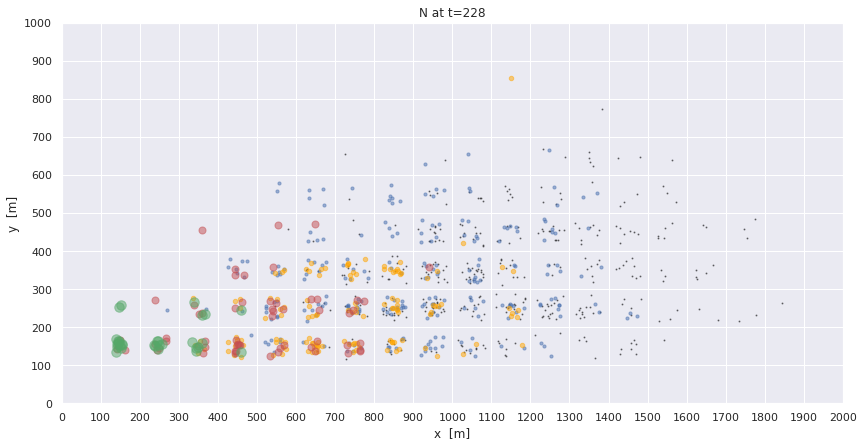

In [6]:
#Working on making a nicer video with slower movement in the individual cells
plot_scatter_movie(N,150,250,name='smoke',dx=dx,dy=dy,figsize=(14,7))


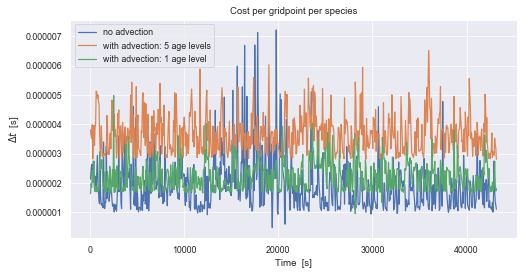

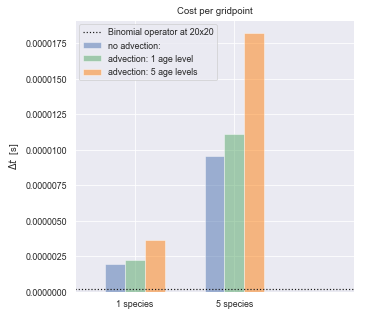

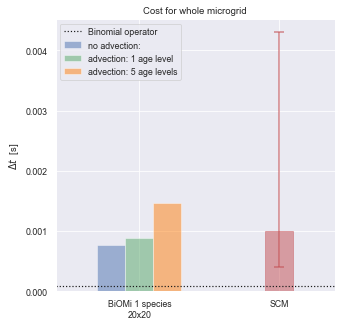

In [202]:
sns.set_context('paper')

fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot( tim, dt_diag[0,:], label='no advection'       )
ax.plot( tim, dt_diag[1,:], label='with advection: 5 age levels'       )
ax.plot( tim, dt_diag[2,:], label='with advection: 1 age level'       )

ax.legend()

ax.set_title("Cost per gridpoint per species" )
ax.set_xlabel("%s  [%s]" % ("Time","s"))
ax.set_ylabel("%s  [%s]" % ("$\Delta t$","s"))

#ax.set_ylim([0,8e-6])

plt.show()

plt.close(fig)


###### bar plot ########################

fig,ax = plt.subplots(1,1,figsize=(5,5))

index = np.arange(1)
bar_width = 0.2
opacity = 0.5

#-- plot 1 ---
rects1 = ax.bar(index - 1*bar_width  , np.mean(dt_diag[0,:],axis=0), bar_width,
alpha=opacity,
color='b',
label='no advection: ')

rects2 = ax.bar(index                , np.mean(dt_diag[2,:],axis=0), bar_width,
alpha=opacity,
color='g',
label='advection: 1 age level')

rects3 = ax.bar(index + 1*bar_width  , np.mean(dt_diag[1,:],axis=0), bar_width,
alpha=opacity,
color='tab:orange',
label='advection: 5 age levels')

rects4 = ax.bar(index+1 - 1*bar_width, np.mean(dt_diag[0,:]*nsiz,axis=0), bar_width,
alpha=opacity,
color='b')

rects5 = ax.bar(index+1               , np.mean(dt_diag[2,:]*nsiz,axis=0), bar_width,
alpha=opacity,
color='g')

rects6 = ax.bar(index+1 + 1*bar_width , np.mean(dt_diag[1,:]*nsiz,axis=0), bar_width,
alpha=opacity,
color='tab:orange')

ax.plot([-nadv*bar_width,1+2*nadv*bar_width], [2e-7,2e-7], ':', color='k', label="Binomial operator at 20x20"  )

index2 = np.arange(2)
xticklab = ["1 species", "5 species"]
ax.set_xticks(index2)
ax.set_xticklabels(xticklab)

ax.legend()

ax.set_title("Cost per gridpoint" )
ax.set_ylabel("%s  [%s]" % ("$\Delta t$","s"))

#ax.set_ylim([0,8e-6])
ax.set_xlim([-nadv*bar_width,1+2*nadv*bar_width])

plt.show()

fig.savefig('N_ecasc_cost_bar1.png',bbox_inches = 'tight')
fig.savefig('N_ecasc_cost_bar1.pdf',bbox_inches = 'tight')

plt.close(fig)


#-- plot 2 ---
fig,ax = plt.subplots(1,1,figsize=(5,5))

rects1 = ax.bar(index - 1*bar_width  , np.mean(dt_diag[0,:]*nx*ny,axis=0), bar_width,
alpha=opacity,
color='b',
label='no advection: ')

rects2 = ax.bar(index                , np.mean(dt_diag[2,:]*nx*ny,axis=0), bar_width,
alpha=opacity,
color='g',
label='advection: 1 age level')

rects3 = ax.bar(index + 1*bar_width  , np.mean(dt_diag[1,:]*nx*ny,axis=0), bar_width,
alpha=opacity,
color='tab:orange',
label='advection: 5 age levels')


rects4 = ax.bar( index+1, [0.001], bar_width,  #hatch='o',
yerr = [ [0.0006],[0.0033] ],edgecolor='r',
error_kw=dict(ecolor='r', lw=2, capsize=5, capthick=2,alpha=opacity),
alpha=opacity,
color='r')

ax.plot([-nadv*bar_width,1+2*nadv*bar_width], nx*ny*np.array([2e-7,2e-7]), ':', color='k', label="Binomial operator"  )

xticklab = ["BiOMi 1 species\n20x20", "SCM"]
ax.set_xticks(index2)
ax.set_xticklabels(xticklab)

ax.legend()

ax.set_title("Cost for whole microgrid" )
ax.set_ylabel("%s  [%s]" % ("$\Delta t$","s"))

ax.set_xlim([-nadv*bar_width,1+2*1*bar_width])
#ax[1].set_ylim([0,1.5*np.max(np.mean(dt_diag[:,:]*nx*ny,axis=1))])


plt.show()

fig.savefig('N_ecasc_cost_bar2.png',bbox_inches = 'tight')
fig.savefig('N_ecasc_cost_bar2.pdf',bbox_inches = 'tight')

plt.close(fig)

